In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file = pd.read_excel('/content/drive/MyDrive/Bài tập DA/ML/[K22] Final Project/churn_prediction.xlsx',sheet_name='Sheet1')
dataset=file.copy()

# 1. Data processing

In [150]:
# Check data balance
dataset['Churn'].value_counts(normalize = True)

Churn
0    0.831616
1    0.168384
Name: proportion, dtype: float64

Tỉ lệ là 16% -> quite imbalance -> build ML như bình thường

In [151]:
# Kiểm tra missing value
dataset.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [152]:
#Tỉ lệ observation có missing value
100*dataset.isnull().any(axis=1).sum()/dataset.shape[0]

32.96625222024867

Tỉ lệ missing value lớn => không xóa mà replace

In [153]:
# List các cột có missing value
miss_col=dataset.columns[dataset.isnull().any()].tolist()
# kiểm tra datatypes của các cột này
dataset[miss_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tenure                       5366 non-null   float64
 1   WarehouseToHome              5379 non-null   float64
 2   HourSpendOnApp               5375 non-null   float64
 3   OrderAmountHikeFromlastYear  5365 non-null   float64
 4   CouponUsed                   5374 non-null   float64
 5   OrderCount                   5372 non-null   float64
 6   DaySinceLastOrder            5323 non-null   float64
dtypes: float64(7)
memory usage: 308.0 KB


Tất cả các cột missing value thì đều là numerical value => replace bằng mean/median

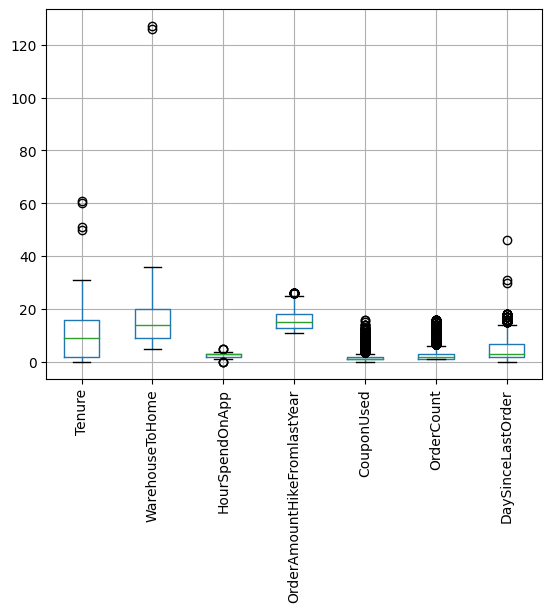

In [154]:
#Check xem các feature có missing value thì có outliner ko để lựa chọn replace bằng mean hay median
import matplotlib.pyplot as plt
dataset[miss_col].boxplot()
plt.xticks(rotation=90)
plt.show()

Tất cả đều có outliner -> replace bằng median

In [155]:
#fill missing value with trung vị
for i in miss_col:
    dataset[[i]]=dataset[[i]].fillna(dataset[[i]].median())

# 2. Tìm mối quan hệ với các feature

In [156]:
#Kiểm tra xem cột CustomerID có duplicate không
dataset[['CustomerID']].duplicated().sum()

0

## Xét feature complain và satisfaction score

In [157]:
# Tính số lượng churn theo Complain
df1 = dataset.pivot_table(values='CustomerID',index='Complain',columns='Churn',margins=True,aggfunc='count')
# Tính % churn ở từng loại Complain
df1['% Churn']=100*df1[1]/df1['All']
print(df1)

Churn        0    1   All    % Churn
Complain                            
0         3586  440  4026  10.928962
1         1096  508  1604  31.670823
All       4682  948  5630  16.838366


Tỉ lệ churn ở những users complain là cao hơn so với những người không complain

In [158]:
# Tính số lượng churn theo điểm hài lòng
df2 = dataset.pivot_table(values='CustomerID',index='SatisfactionScore',columns='Churn',margins=True,aggfunc='count')
# Tính % churn ở từng loại Complain
df2['% Churn']=100*df2[1]/df2['All']
print(df2)

Churn                 0    1   All    % Churn
SatisfactionScore                            
1                  1030  134  1164  11.512027
2                   512   74   586  12.627986
3                  1406  292  1698  17.196702
4                   890  184  1074  17.132216
5                   844  264  1108  23.826715
All                4682  948  5630  16.838366


Tỉ lệ churn cao ở những người có điểm hài lòng là 4,5

In [159]:
#Kết hợp cả 2 yếu tố để đánh giá
df3=dataset.pivot_table(values='CustomerID',index='SatisfactionScore',columns=['Complain','Churn'],aggfunc='count')

In [160]:
print(df3)

Complain              0         1     
Churn                 0    1    0    1
SatisfactionScore                     
1                   736   56  294   78
2                   384   32  128   42
3                  1098  128  308  164
4                   726   80  164  104
5                   642  144  202  120


In [161]:
df3[0]=df3.iloc[:,1]/(df3.iloc[:,1]+df3.iloc[:,0])
df3[1]=df3.iloc[:,3]/(df3.iloc[:,3]+df3.iloc[:,2])

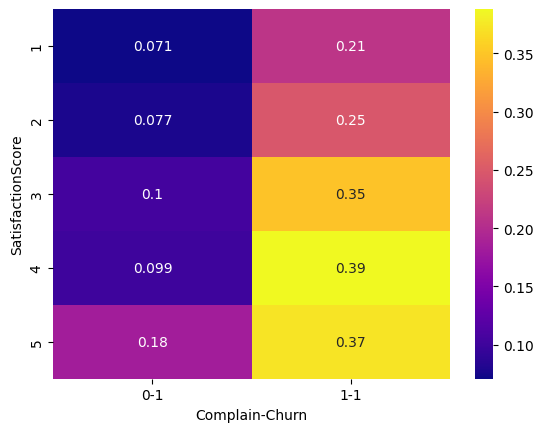

In [162]:
sns.heatmap(df3.iloc[:,[1,3]],cmap='plasma',annot=True)
plt.show()

Tỉ lệ churn ở những người có complain và điểm hài lòng của họ là 3,4,5

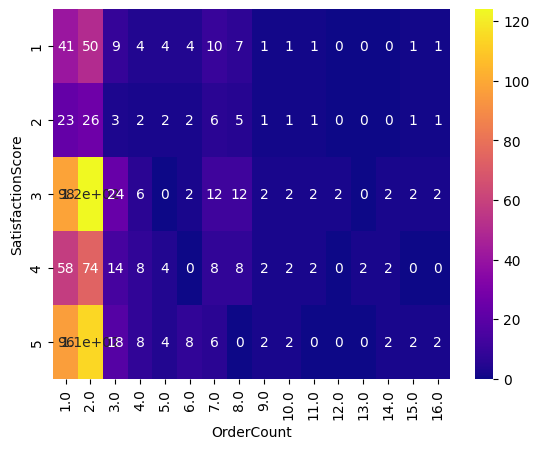

In [163]:
sns.heatmap(data=dataset[dataset['Churn']==1].pivot_table(values='CustomerID',index='SatisfactionScore',columns='OrderCount',aggfunc='count',fill_value=0),cmap='plasma',annot=True)
plt.show()

Những người churn mà có điểm hài lòng 3,4,5 đa số mua 1-2 lần

## Xét feature số lượng order và coupon sử dụng

In [164]:
df4=dataset[dataset['Churn']==1].pivot_table(values='CustomerID',index='CouponUsed',columns='OrderCount',fill_value=0,aggfunc='count')

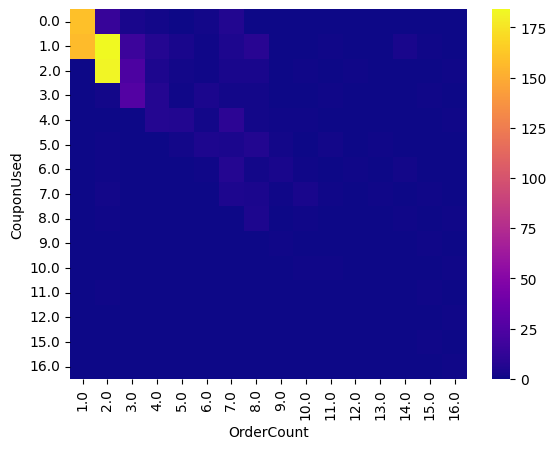

In [165]:
sns.heatmap(df4,cmap='plasma')
plt.show()

Đa số churn users order 1-2 lần và số coupon họ sử dụng cũng là 0-2

## Xét feature về Tenure và DaySinceLastOrder

In [166]:
dataset[dataset['Churn']==1]['Tenure'].value_counts(normalize = True).sort_values(ascending=False)

Tenure
1.0     0.368143
0.0     0.286920
9.0     0.098101
4.0     0.021097
3.0     0.018987
20.0    0.016878
7.0     0.016878
8.0     0.016878
5.0     0.016878
10.0    0.014768
2.0     0.014768
14.0    0.014768
13.0    0.013713
19.0    0.012658
16.0    0.010549
21.0    0.010549
15.0    0.010549
11.0    0.010549
6.0     0.008439
12.0    0.007384
18.0    0.006329
17.0    0.004219
Name: proportion, dtype: float64

In [167]:
dataset[dataset['Churn']==1]['DaySinceLastOrder'].value_counts(normalize = True).sort_values(ascending=False)

DaySinceLastOrder
3.0     0.194093
1.0     0.191983
0.0     0.179325
2.0     0.128692
8.0     0.069620
7.0     0.068565
4.0     0.061181
5.0     0.029536
9.0     0.029536
6.0     0.016878
10.0    0.010549
11.0    0.008439
14.0    0.004219
15.0    0.004219
12.0    0.002110
46.0    0.001055
Name: proportion, dtype: float64

In [168]:
df5=dataset[dataset['Churn']==1].pivot_table(values='CustomerID',index='Tenure',columns="DaySinceLastOrder",aggfunc='count',fill_value=0)

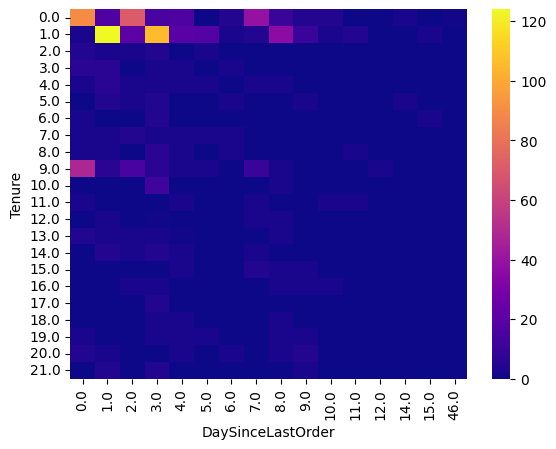

In [169]:
sns.heatmap(df5,cmap='plasma')
plt.show()

Đa số churn user là những người đăng ký tài khoản được 0-1 ngày và họ churn luôn trong 0-5 ngày

In [170]:
# Xem xét độ tương quan
dataset[dataset['Churn']==1]['Tenure'].corr(dataset[dataset['Churn']==1]['DaySinceLastOrder']).round(decimals=2)

0.1

## Check feature về location: CityTier, Warehousetohome

In [171]:
# Xét tỉ lệ churn ở từng loại City
df6=dataset.pivot_table(values='CustomerID',index='CityTier',columns='Churn',aggfunc='count',margins=True)
df6['% Churn']=100*df6[1]/df6['All']
print(df6)

Churn        0    1   All    % Churn
CityTier                            
1         3134  532  3666  14.511729
2          194   48   242  19.834711
3         1354  368  1722  21.370499
All       4682  948  5630  16.838366


Nhóm City Tier 3 có tỉ lệ churn cao nhất.

In [172]:
# Khoảng cách từ kho đến users phổ biến của churn users và số địa chỉ mà họ sử dụng
dataset[dataset['Churn']==1].groupby('CityTier')[['WarehouseToHome','NumberOfAddress']].agg(pd.Series.mode)

,WarehouseToHome,NumberOfAddress
CityTier,,
1,14.0,2
2,"[14.0, 29.0]",2
3,"[7.0, 16.0]",3


In [173]:
# khoảng cách từ kho đến home và số địa chỉ của đa số người dùng
dataset.groupby('CityTier')[['WarehouseToHome','NumberOfAddress']].agg(pd.Series.mode)

,WarehouseToHome,NumberOfAddress
CityTier,,
1,14.0,2
2,9.0,2
3,9.0,2


Ở city tier 2 và 3 thì người dùng churn thường có khoảng cách xa so với đại số

## Xét theo các feature về sở thích cá nhân (ngành hàng, thiết bị yêu thích và phương thức thanh toán yêu thích

In [174]:
#Check feature ngành hàng yêu thích
df7=dataset.pivot_table(values='CustomerID',index='PreferedOrderCat',columns='Churn',aggfunc='count',margins=True)
df7['% Churn']=100*df7[1]/df7['All']
print(df7)

Churn                  0    1   All    % Churn
PreferedOrderCat                              
Fashion              698  128   826  15.496368
Grocery              390   20   410   4.878049
Laptop & Accessory  1840  210  2050  10.243902
Mobile               589  220   809  27.194067
Mobile Phone         921  350  1271  27.537372
Others               244   20   264   7.575758
All                 4682  948  5630  16.838366


Tỉ lệ Churn cao ở ngành hàng Mobile và Mobile Phone. Đa số khách hàng churn thì có ngành hàng yêu thích là Mobile, Mobile Phone, Laptop & Accessory

In [175]:
# Check phương thức thanh toán yêu thích
df8=dataset.pivot_table(values='CustomerID',index='PreferredPaymentMode',columns='Churn',aggfunc='count',margins=True)
df8['% Churn']=100*df8[1]/df8['All']
print(df8)

Churn                    0    1   All    % Churn
PreferredPaymentMode                            
CC                     214   59   273  21.611722
COD                    260  105   365  28.767123
Cash on Delivery       126   23   149  15.436242
Credit Card           1308  193  1501  12.858095
Debit Card            1958  356  2314  15.384615
E wallet               474  140   614  22.801303
UPI                    342   72   414  17.391304
All                   4682  948  5630  16.838366


Tỉ lệ churn cao ở những người có phương thức thanh toán yêu thích là qua E-wallet, COD, CC

In [176]:
# Check thiết bị yêu thích
df9=dataset.pivot_table(values='CustomerID',index='PreferredLoginDevice',columns='Churn',aggfunc='count',margins=True)
df9['% Churn']=100*df9[1]/df9['All']
print(df9)

Churn                    0    1   All    % Churn
PreferredLoginDevice                            
Computer              1310  324  1634  19.828641
Mobile Phone          2417  348  2765  12.585895
Phone                  955  276  1231  22.420796
All                   4682  948  5630  16.838366


Tỉ lệ churn cao ở những người thích login bằng Phone và Computer

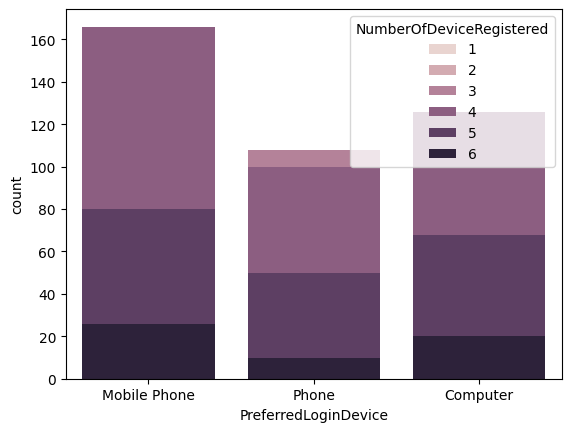

In [177]:
sns.countplot(dataset[dataset['Churn']==1],x='PreferredLoginDevice',hue='NumberOfDeviceRegistered',dodge=False)
plt.show()

Với tất cả những người churn có sở thích sử dụng thiết bị đăng nhập khác nhau thì đa số đều đăng kí 4-5 thiết bị

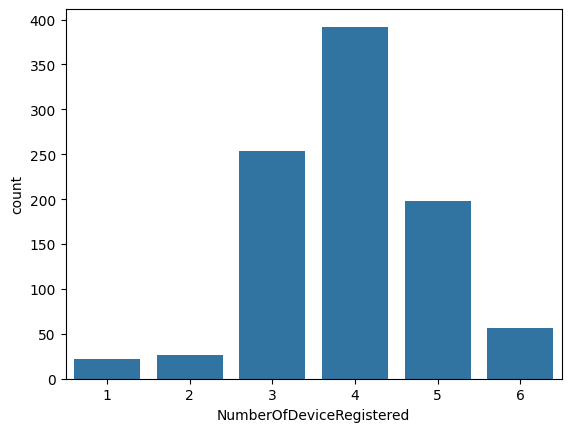

In [178]:
sns.countplot(dataset[dataset['Churn']==1],x='NumberOfDeviceRegistered')
plt.show()

Đa số churn users đã đăng kí 3-4 thiết bị

# Đề xuất
- Cải thiên chất lượng dịch vụ để hạn chế Complain vì tỉ lệ churn cao ở những user có complain
- Những churn user thường mua 1-2 lần. Đa số những lần đó họ sẽ để lại đánh giá hài lòng là 3-5 điểm. Như vậy khi có khách hàng đánh giá tốt thì cần thúc đẩy họ mua nhiều lần hơn để giảm thiểu khả năng họ sẽ churn
- Khách hàng churn đa số là những người chỉ mua 1-2 lần và số lượng coupon họ sử dụng là ít 0-2 lần. Đề xuất quảng bá các chương trình coupon tới khách hàng mới, tăng số lượng coupon khách hàng mới mua lần đầu, hoặc lần 2 có thể sử dụng. Ví dụ với lần mua thứ 2 bạn sẽ có thêm 1 coupon sử dụng vào lần mua sau
- Tỉ lệ churn của người dùng ở thành phố hạng 2,3 cao. Ở thành phố 2,3, đa số những churn user có khoảng cách từ kho hàng tới nhà họ là xa hơn so với mặt bằng chung => Đề xuất tăng cường các kho hàng ở gần khu vực thành phố 2,3 để giảm khoảng cách ship/chi phí ship
- Ngành hàng có tỉ lệ churn cao nhất là Mobile, Mobile Phone, Laptop => tìm hiểu nhu cầu khách hàng để đưa ra sản phẩm phù hợp/ tăng cường cải thiện chất lượng dịch vụ ở ngành hàng này
- Tỉ lệ churn cao ở những người có phương thức thanh toán yêu thích là qua E-wallet, COD, CC => Đề xuất thêm phương thức thanh toán nếu chưa có. Cải thiện tốc độ thanh toán, thêm các hình thức giảm giá với các hình thức thanh toán là E-wallet, COD,...
- Đa số người dùng thích sử dụng MobilePhone để login, nhưng ở những người thích dùng Computer và Phone thì họ lại có tỉ lệ churn cao hơn => Xây dựng các platform trên Phone và Computer, hoặc nếu có thì cải thiện giao diện sao cho gần gũi với người dùng
- Đa số churn user đều đăng ký 4-5 thiết bị => Giả thuyết: họ phải đăng ký nhiều để lấy coupon hoặc họ gặp trục trặc trong việc sử dụng nền tảng trên 1 thiết bị nên phải đăng ký nhiều => Cần cải thiện sao cho platform mượt mà hơn, tránh những lỗi không thể vận hành ở những máy mà đại đa số đông người dùng.

# 2. Build model - Prepare dataset

## Feature Engineering

In [179]:
# Xác định các cột là category
str_col=dataset.select_dtypes(include=['object']).columns

In [180]:
# Dùng pd.get_dummies để biến đổi sang dạng numerical
df=pd.get_dummies(dataset,columns=str_col)

## Split data

In [181]:
X=df.drop(['Churn','CustomerID'],axis=1).values
y=df[['Churn']].values

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,stratify=y,random_state=42)

## Scale data

In [183]:
list_columns=df.drop(['Churn','CustomerID'],axis=1).columns.tolist()
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.fit_transform(X_test)
y_train=y_train.ravel()

# 3.Model Selection

## Dùng Decision Tree

In [184]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score,confusion_matrix,classification_report
# Khởi tạo model
clf_tree=DecisionTreeClassifier(random_state=1)
# fit với training data
clf_tree.fit(scaled_X_train,y_train)
# predict với test & train set
tree_y_pred_test=clf_tree.predict(scaled_X_test)
tree_y_pred_train=clf_tree.predict(scaled_X_train)

#tính balanced accuracy score
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, tree_y_pred_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, tree_y_pred_test)}')

# Kiểm tra confusion matrix
print(confusion_matrix(y_test,tree_y_pred_test))
print(classification_report(y_test,tree_y_pred_test))

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.841556293102557
[[1396  149]
 [  69  244]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1545
           1       0.62      0.78      0.69       313

    accuracy                           0.88      1858
   macro avg       0.79      0.84      0.81      1858
weighted avg       0.90      0.88      0.89      1858



## Dùng Random Forest

In [185]:
from sklearn.ensemble import RandomForestClassifier
# Khởi tạo model
clf_rand=RandomForestClassifier(random_state=1)
#fit với training data
clf_rand.fit(scaled_X_train,y_train)
#predict với train và test set
rand_y_pred_test=clf_rand.predict(scaled_X_test)
rand_y_pred_train=clf_rand.predict(scaled_X_train)
#tính balanced accuracy score
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, rand_y_pred_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, rand_y_pred_test)}')
# Kiểm tra confusion matrix
print(confusion_matrix(y_test, rand_y_pred_test))
print(classification_report(y_test, rand_y_pred_test))

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.8267667524840514
[[1528   17]
 [ 105  208]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1545
           1       0.92      0.66      0.77       313

    accuracy                           0.93      1858
   macro avg       0.93      0.83      0.87      1858
weighted avg       0.93      0.93      0.93      1858



## Dùng Logistic Regression

In [186]:
from sklearn.linear_model import LogisticRegression
clf_lore=LogisticRegression()
clf_lore.fit(scaled_X_train,y_train)
lore_y_pred_test=clf_lore.predict(scaled_X_test)
lore_y_pred_train=clf_lore.predict(scaled_X_train)
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, lore_y_pred_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, lore_y_pred_test)}')
# Kiểm tra confusion matrix
print(confusion_matrix(y_test, lore_y_pred_test))
print(classification_report(y_test, lore_y_pred_test))

Balance accuracy of train set: 0.7226915730210166
Balance accuracy of test set: 0.6797812173661301
[[1523   22]
 [ 196  117]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      1545
           1       0.84      0.37      0.52       313

    accuracy                           0.88      1858
   macro avg       0.86      0.68      0.73      1858
weighted avg       0.88      0.88      0.86      1858



## So sánh, đánh giá để chọn model

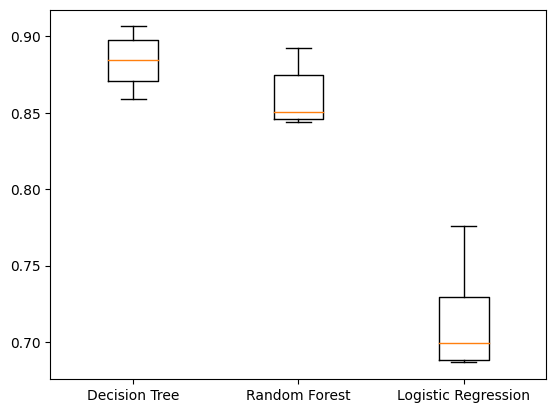

In [205]:
#Test theo balanced accuracy
from sklearn.model_selection import cross_val_score, KFold
models={"Decision Tree":clf_tree,"Random Forest":clf_rand,"Logistic Regression":clf_lore}
results=[]
for model in models.values():
  kf=KFold(n_splits=6,random_state=42,shuffle=True)
  cv_result=cross_val_score(model,scaled_X_train,y_train,cv=kf,scoring='balanced_accuracy')
  results.append(cv_result)
plt.boxplot(results,labels=models.keys())
plt.show()

##Feature importance => DecisionTree model

Text(0.5, 1.0, 'Feature Important')

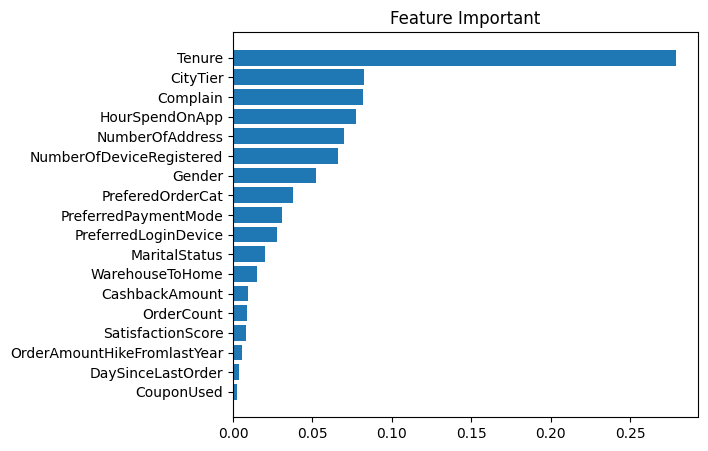

In [188]:
#Tính điểm feature importances
rand_importances=clf_tree.feature_importances_
#Tạo bảng DF lưu trữ feature và điểm importances tương ứng
feat={}
for feature, score in zip(dataset.drop(['Churn','CustomerID'],axis=1).columns,rand_importances):
  feat[feature]=score
importances_score=pd.DataFrame.from_dict(feat,orient='index').rename(columns={0:'gini_importance'})
importances_score=importances_score.sort_values(by='gini_importance',ascending=True).reset_index()
# Vẽ plot
plt.figure(figsize=(6, 5))
plt.barh(importances_score.tail(20)['index'][:20], importances_score.tail(20)['gini_importance'])

plt.title('Feature Important')

In [189]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
rfe=RFECV(estimator=clf_tree,scoring='balanced_accuracy', n_jobs=-1)
pipeline=Pipeline(steps=[('selection',rfe)])

## Hyperparameter tuning

In [196]:
#Trial 1
from sklearn.model_selection import GridSearchCV
param_grid={
    'max_depth':[None,2,5,15,25,30,50,100,200],
    'min_samples_split':[2,5,15,25,50,100],
    'min_samples_leaf':[2,5,7,15,25,50],
    'max_features':[1,2,3,5,7,15,25,34],
    'class_weight':[{0:0.1,1:0.9},{0:1,1:1},{0:1,1:2},{0:1,1:3}]
}
grid_search=GridSearchCV(clf_tree,param_grid,cv=5,scoring='balanced_accuracy',n_jobs=-1)
grid_search.fit(scaled_X_train,y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best score: ",grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 3}, 'max_depth': None, 'max_features': 25, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:  0.8830229948552015


In [197]:
# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(scaled_X_test, y_test)
print("Test set accuracy: ", accuracy)

Test set accuracy:  0.8794402583423035


In [198]:
best_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 25,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [199]:
y_pred_final_test=best_clf.predict(scaled_X_test)
y_pred_final_train=best_clf.predict(scaled_X_train)
print(classification_report(y_test,y_pred_final_test))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1545
           1       0.61      0.78      0.69       313

    accuracy                           0.88      1858
   macro avg       0.78      0.84      0.81      1858
weighted avg       0.90      0.88      0.89      1858



In [206]:
print("test balanced score: ",100*balanced_accuracy_score(y_test,y_pred_final_test))
print("train_balanced_score: ",100*balanced_accuracy_score(y_train,y_pred_final_train))

test balanced score:  84.0888365023729
train_balanced_score:  99.2030602486452
